Install and load all the requirements:

In [ ]:
%pip install -r requirements.txt

In [1]:
import albumentations as A
import numpy as np
import rasterio as rio
import torch

from glpdepth.model import GLPDepth
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision.transforms import v2


data_dir = Path("/home/super/datasets-nas/HiRISE")  # replace with your path to the scraped dataset
device = "cuda" if torch.cuda.is_available else "cpu"

/home/super/.local/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/super/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Show a sample from the train set:

/home/super/.local/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


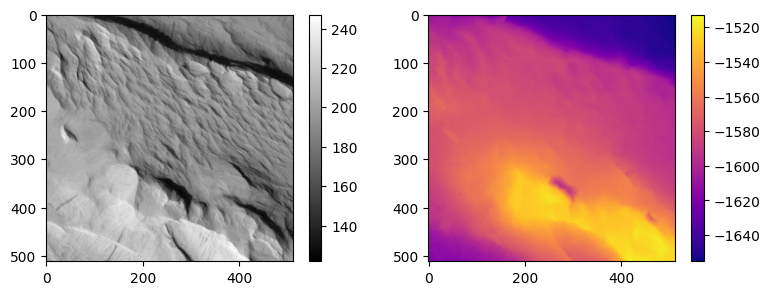

In [2]:
test_split = Path.cwd() / "splits" / "train.txt"
tiles = test_split.read_text().splitlines()

# take the first tile from the train set
with rio.open(data_dir / tiles[0], "r") as ds:
    image = ds.read(1).astype("uint8")
    dtm_abs = ds.read(2)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
img1 = ax1.imshow(image, cmap="gray")
img2 = ax2.imshow(dtm_abs, cmap="plasma")
fig.colorbar(img1, ax=ax1)
fig.colorbar(img2, ax=ax2)
fig.tight_layout()

Rescale absolute heights to relative depths:

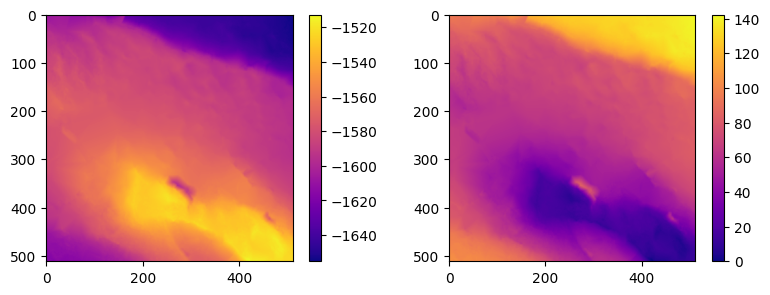

In [3]:
dtm_rel = abs(dtm_abs - dtm_abs.max())

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
img1 = ax1.imshow(dtm_abs, cmap="plasma")
img2 = ax2.imshow(dtm_rel, cmap="plasma")
fig.colorbar(img1, ax=ax1)
fig.colorbar(img2, ax=ax2)
fig.tight_layout()

Just simple augmentations were used. Run the piece of code multiple times to show the different effects:

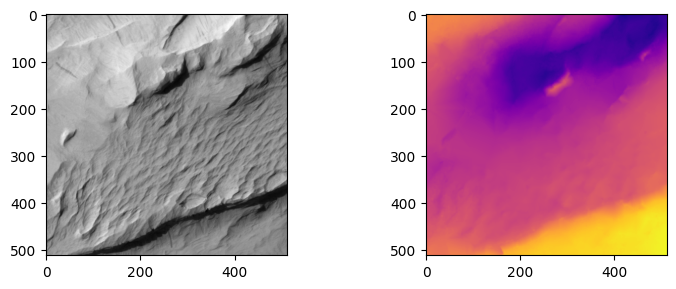

In [4]:
transform = A.Compose([A.HorizontalFlip(), A.VerticalFlip()])
transformed = transform(image=image, mask=dtm_rel)
image_aug = transformed["image"]
dtm_aug = transformed["mask"]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
img1 = ax1.imshow(image_aug, cmap="gray")
img2 = ax2.imshow(dtm_aug, cmap="plasma")
fig.tight_layout()

After training the model, it can be used this way:

/home/super/.local/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


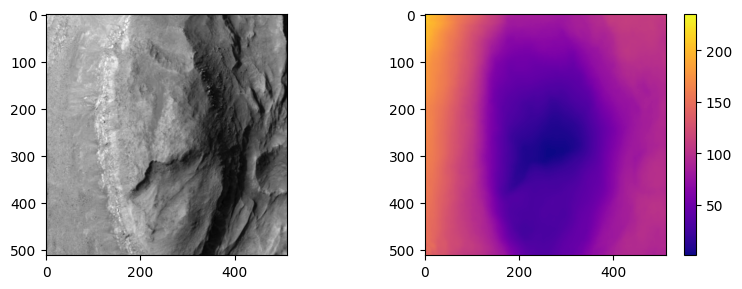

In [40]:
model = GLPDepth(max_depth=700.0).to(device)
weights_path = Path("/home/super/mgatti/MarsDEM/pretrained/best_model.ckpt")
weights = torch.load(weights_path, map_location=torch.device("cpu"))["state_dict"]
weights = {k[6:]:v for (k, v) in weights.items()}  # to remove "model."" before each key of the state_dict
model.load_state_dict(weights)
model.eval()

example_path = Path("examples/example_1.jpg")
pil_image = Image.open(example_path).convert("L")
to_tensor = v2.ToTensor()
torch_image = to_tensor(pil_image).to(device).unsqueeze(0)

with torch.no_grad():
    pred_dtm = model(torch_image).squeeze().cpu()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
img1 = ax1.imshow(torch_image.squeeze().cpu(), cmap="gray")
img2 = ax2.imshow(pred_dtm, cmap="plasma")
fig.colorbar(img2, ax=ax2)
fig.tight_layout()

Then the depths can be converted to relative heights:

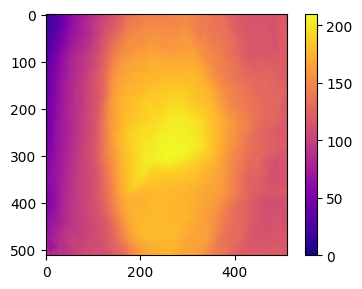

In [6]:
pred_dtm = abs(pred_dtm - pred_dtm.max())
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
img1 = ax1.imshow(pred_dtm, cmap="plasma")
fig.colorbar(img1, ax=ax1)
fig.tight_layout()